## Testing of BLIP2-Pretrained Model

In [ ]:
%pip install bitsandbytes
%pip install accelerate

In [1]:
import cv2
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

In [1]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

d:\notebook\deeplearning_crash_course\dl_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/home/arafat/projects/flow_matching_and_llm")

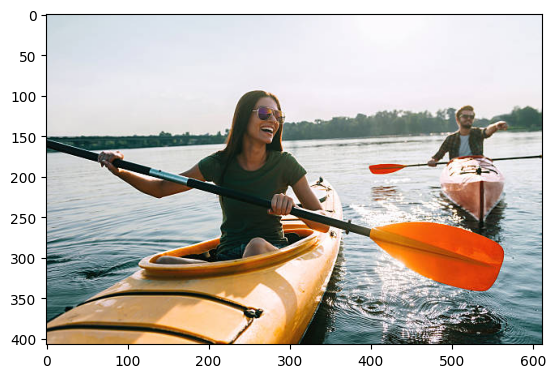

In [4]:
image = cv2.imread('../data/images/istockphoto-610864024-612x612.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

**Initialize Blip2Processor**

In [2]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b", cache_dir="../data/cache")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
d:\notebook\deeplearning_crash_course\dl_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\notebook\deeplearning_crash_course\data\cache\models--Salesforce--blip2-opt-2.7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need t

In [ ]:
encoding = processor(images=image, text="An Image of ")
for k, _ in encoding.items():
    print(k)

In [7]:
input_ids = torch.tensor(encoding['input_ids'])
pixel_values = torch.from_numpy(np.array(encoding['pixel_values']))
print(f"Input_ids: {input_ids.shape}")
print(f"pixel values: {pixel_values.shape}")

Input_ids: torch.Size([1, 37])
pixel values: torch.Size([1, 3, 224, 224])


**Download Model**

In [1]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl",
                                                    load_in_4bit=True,
                                                    cache_dir="../data/cache")

NameError: name 'Blip2ForConditionalGeneration' is not defined

In [ ]:
prompts = "An Image of"
inputs = processor(images=image, texts=prompts, return_tensors='pt').to(torch.device("cpu"), dtype=torch.float16)

output_ids = model.generate(**inputs)

In [ ]:
generated_text = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

### Fine Tuning

In [ ]:
from transformers import Blip2VisionConfig, Blip2QFormerConfig, Blip2Config

In [ ]:
vision_config = Blip2VisionConfig()